In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from fastai import *
from fastai.vision import *

# Data

In [12]:
path = untar_data(URLs.BIWI_HEAD_POSE); path

PosixPath('/home/jupyter/.fastai/data/biwi_head_pose')

In [26]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [27]:
fname = '09/frame_00667_rgb.jpg'

In [28]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

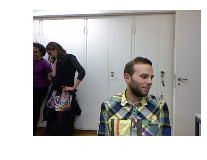

In [31]:
img = open_image(path/fname)
img.show()

In [32]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [33]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [34]:
get_ctr(fname)

tensor([263.9104, 428.5814])

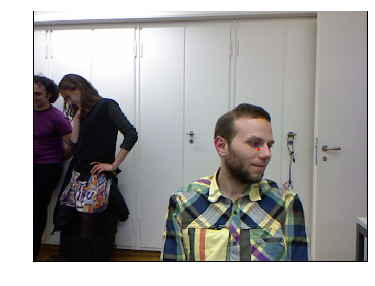

In [35]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

In [55]:
img.shape

torch.Size([3, 480, 640])

In [50]:
get_ip(get_ctr(db.train.items[0])

tensor([254.4287, 367.2483])

In [59]:
bs = 64
size = np.array(img.shape[1:]) // 2; size

array([240, 320])

In [53]:
tfms = get_transforms()

In [60]:
db = (PointsItemList.from_folder(path)
     .split_by_valid_func(lambda o: o.parent.stem == '13')
     .label_from_func(get_ctr)
     .transform(tfms, tfm_y=True, size=size)
     .databunch(bs=bs)
     .normalize(imagenet_stats))

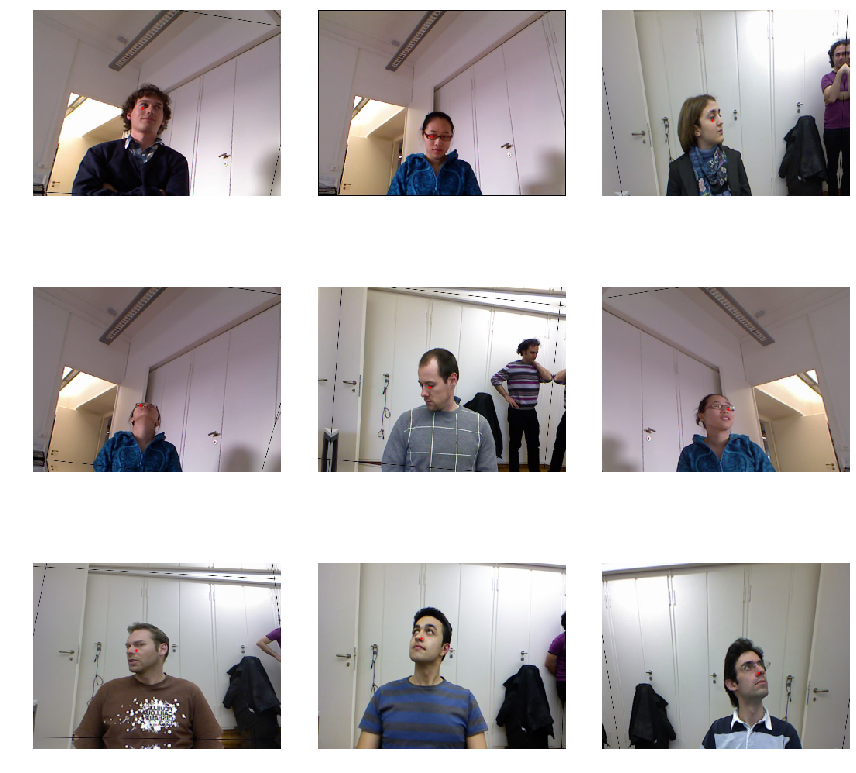

In [61]:
db.show_batch(3)

In [74]:
def _plot(r, c, ax):
    x, y = db.train_ds[0]
    x.show(ax, y=y)

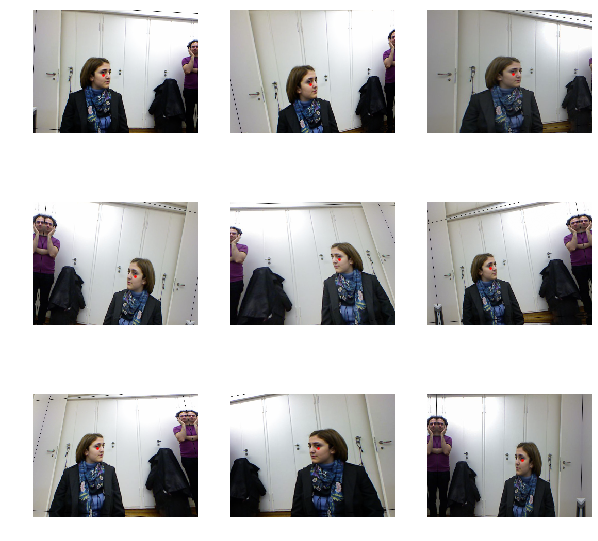

In [76]:
plot_multi(_plot, 3, 3, figsize=(10, 10))

# Train

In [77]:
learn = cnn_learner(db, models.resnet34)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


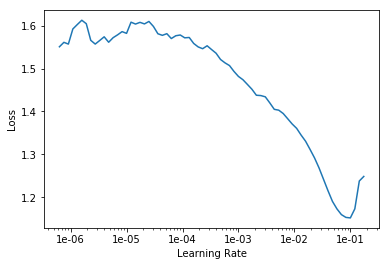

In [78]:
learn.lr_find(); 
learn.recorder.plot()

In [79]:
lr = 2e-2

In [80]:
learn.fit_one_cycle(6, lr)

epoch,train_loss,valid_loss,time
0,0.048243,0.001702,01:13
1,0.013155,0.002300,01:06
2,0.004063,0.001676,01:06
3,0.002597,0.001313,01:06
4,0.001797,0.000814,01:06
5,0.001220,0.000411,01:07


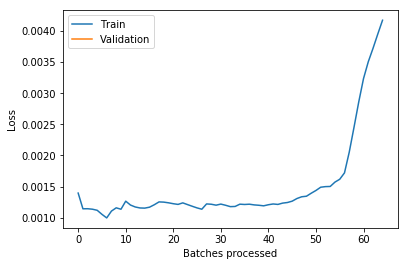

In [90]:
learn.recorder.plot_losses()

In [89]:
learn.save('r34-stage1')

In [91]:
learn.unfreeze()

In [92]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


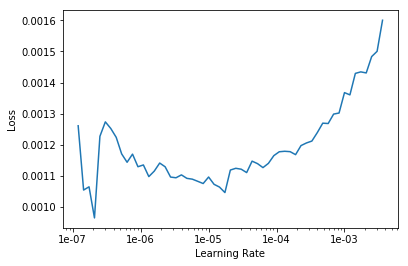

In [95]:
learn.recorder.plot(skip_start=1)

In [96]:
learn.fit_one_cycle(6, max_lr=slice(6e-7, lr/10))

epoch,train_loss,valid_loss,time
0,0.001249,0.000331,01:07
1,0.001352,0.000161,01:08
2,0.001115,0.000042,01:08
3,0.001152,0.000103,01:08
4,0.000893,0.000049,01:08
5,0.000842,0.000176,01:07


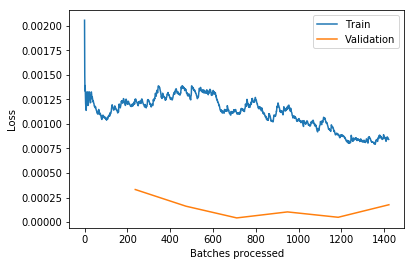

In [97]:
learn.recorder.plot_losses()

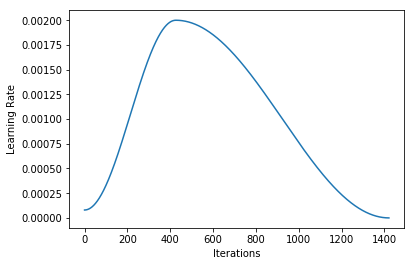

In [99]:
learn.recorder.plot_lr()

In [98]:
learn.save('r34-stage2')

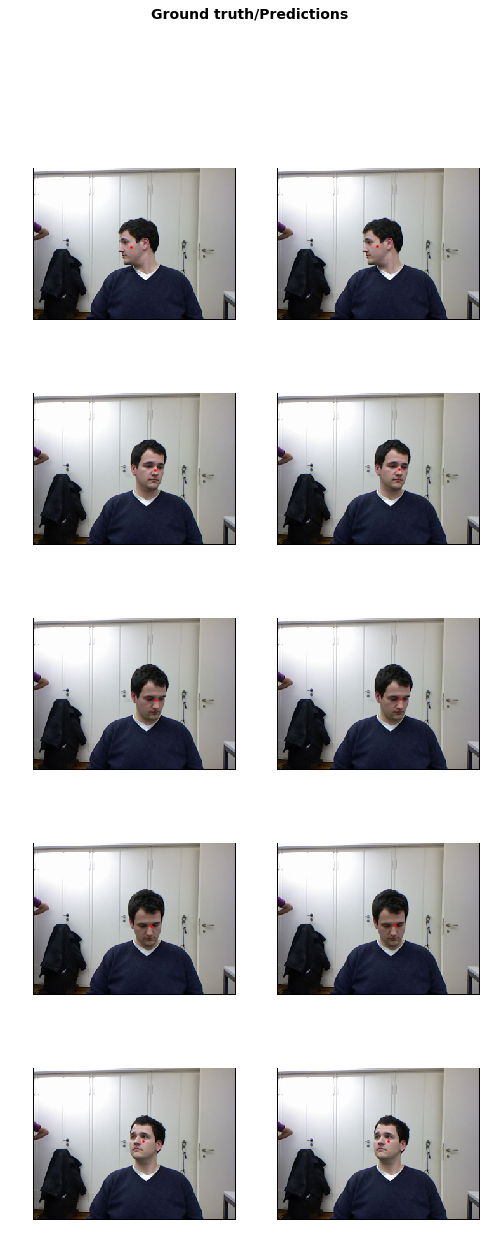

In [100]:
learn.show_results()